# Quickstart
In this notebook, we go over the main functionalities of the library:

* [Installing Darts](#Installing-Darts)
* [Building and manipulating TimeSeries](#Building-and-manipulating-TimeSeries)
* [Training forecasting models and making predictions](#Training-forecasting-models-and-making-predictions)
* [Backtesting](#Backtesting:-simulate-historical-forecasting)
* [Machine learning and global models](#Machine-learning-and-global-models)
* [Covariates: using external data](#Covariates:-using-external-data)
* [Regression forecasting models](#Regression-forecasting-models)
* [Sample weights for training](#Sample-Weights)
* [Forecast Start Shifting](#Forecast-Start-Shifting)
* [Probabilistic forecasts](#Probabilistic-forecasts)
* [Ensembling models](#Ensembling-models)
* [Filtering models](#Filtering-models)
* [Anomaly Detection](#Anomaly-Detection)

We will only show some minimal "get started" examples here. For more in depth information, you can refer to our [user guide](https://unit8co.github.io/darts/userguide.html) and [example notebooks](https://unit8co.github.io/darts/examples.html).

# Installing Darts
We recommend using some virtual environment. Then there are mainly two ways.

With pip:
```
pip install darts
```

With conda
```
conda install -c conda-forge -c pytorch u8darts-all
```

Consult the [detailed install guide](https://github.com/unit8co/darts#installation-guide) if you run into issues or want to install a different flavour (avoiding certain dependencies).

First, let's import a few things:

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.datasets import AirPassengersDataset

# Building and manipulating `TimeSeries`
`TimeSeries` is the main data class in Darts. A `TimeSeries` represents a univariate or multivariate time series, with a proper time index. The time index can either be of type `pandas.DatetimeIndex` (containing datetimes), or of type `pandas.RangeIndex` (containing integers useful for representing sequential data without specific timestamps). In some cases, `TimeSeries` can even represent *probabilistic* series, in order for instance to obtain confidence intervals. All models in Darts consume `TimeSeries` and produce `TimeSeries`.

## Read data and build a `TimeSeries`
`TimeSeries` can be built easily using a few factory methods:

* From an entire Pandas `DataFrame`, using `TimeSeries.from_dataframe()` ([docs](https://unit8co.github.io/darts/generated_api/darts.timeseries.html#darts.timeseries.TimeSeries.from_dataframe)).
* From a time index and an array of corresponding values, using `TimeSeries.from_times_and_values()` ([docs](https://unit8co.github.io/darts/generated_api/darts.timeseries.html#darts.timeseries.TimeSeries.from_times_and_values)).
* From a NumPy array of values, using `TimeSeries.from_values()` ([docs](https://unit8co.github.io/darts/generated_api/darts.timeseries.html#darts.timeseries.TimeSeries.from_values)).
* From a Pandas `Series`, using `TimeSeries.from_series()` ([docs](https://unit8co.github.io/darts/generated_api/darts.timeseries.html#darts.timeseries.TimeSeries.from_series)).
* From an `xarray.DataArray`, using `TimeSeries.from_xarray()` ([docs](https://unit8co.github.io/darts/generated_api/darts.timeseries.html#darts.timeseries.TimeSeries.from_xarray)).
* From a CSV file, using `TimeSeries.from_csv()` ([docs](https://unit8co.github.io/darts/generated_api/darts.timeseries.html#darts.timeseries.TimeSeries.from_csv)).
* Create multiple `TimeSeries` by groups from a Pandas `DataFrame`, using `TimeSeries.from_group_dataframe()` ([docs](https://unit8co.github.io/darts/generated_api/darts.timeseries.html#darts.timeseries.TimeSeries.from_group_dataframe)).

Below, we get a `TimeSeries` by directly loading the air passengers series from one of the datasets available in Darts:

<Axes: xlabel='Month'>

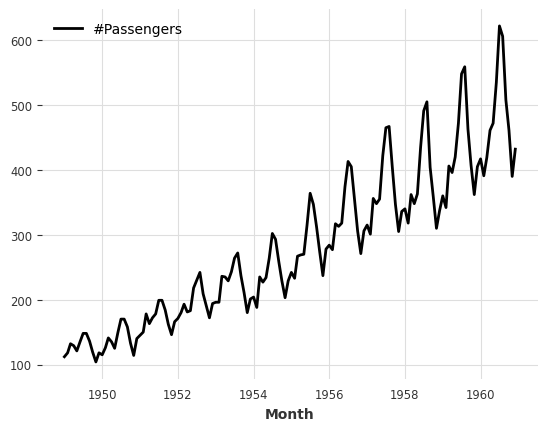

In [2]:
series = AirPassengersDataset().load()
series.plot()

## Some `TimeSeries` Operations
`TimeSeries` support different kinds of operations - here are a few examples.

**splitting**

We can also split at a fraction of the series, at a pandas `Timestamp` or at an integer index value.

<Axes: xlabel='Month'>

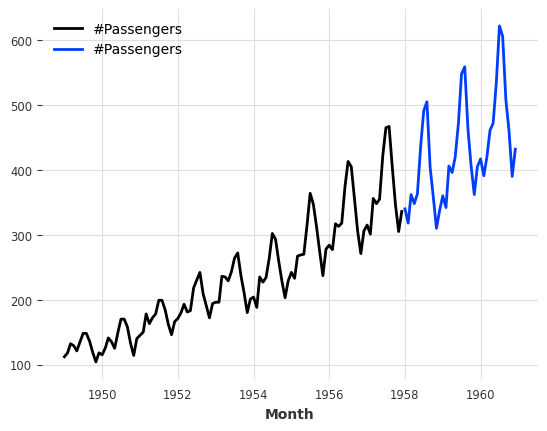

In [3]:
series1, series2 = series.split_after(0.75)
series1.plot()
series2.plot()

**slicing:**

<Axes: xlabel='Month'>

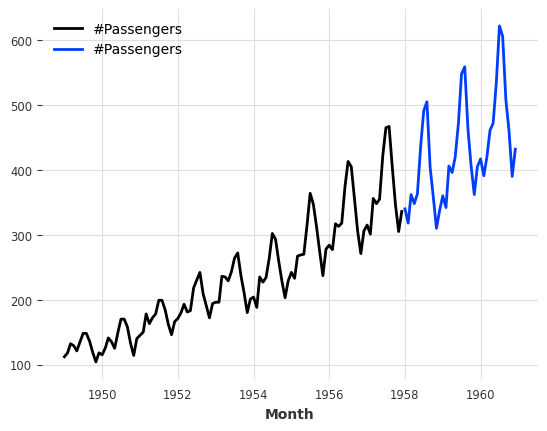

In [4]:
series1, series2 = series[:-36], series[-36:]
series1.plot()
series2.plot()

**arithmetic operations:**

<Axes: xlabel='Month'>

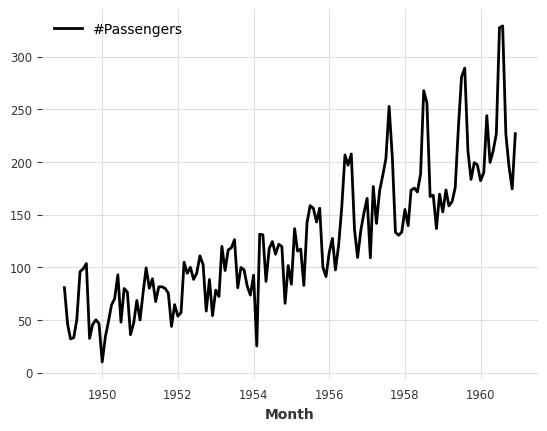

In [5]:
series_noise = TimeSeries.from_times_and_values(
    series.time_index, np.random.randn(len(series))
)
(series / 2 + 20 * series_noise - 10).plot()

**stacking**

Concatenating a new dimension to produce a new single multivariate series.

<Axes: xlabel='Month'>

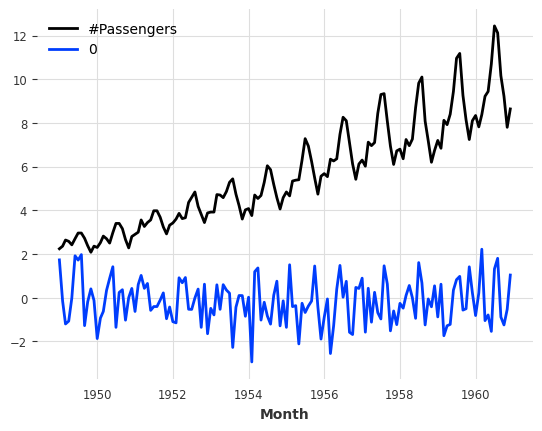

In [6]:
(series / 50).stack(series_noise).plot()

**mapping:**

<Axes: xlabel='Month'>

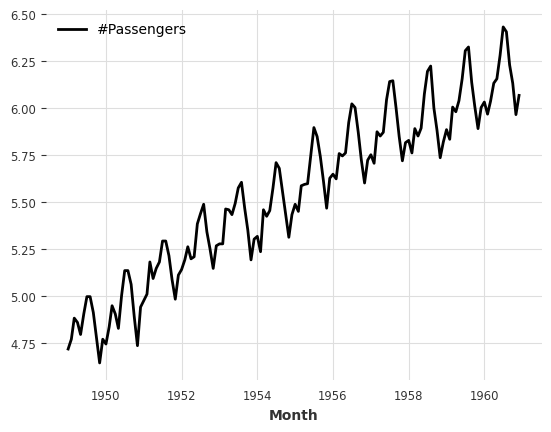

In [7]:
series.map(np.log).plot()

**mapping on both timestamps and values:**

<Axes: xlabel='Month'>

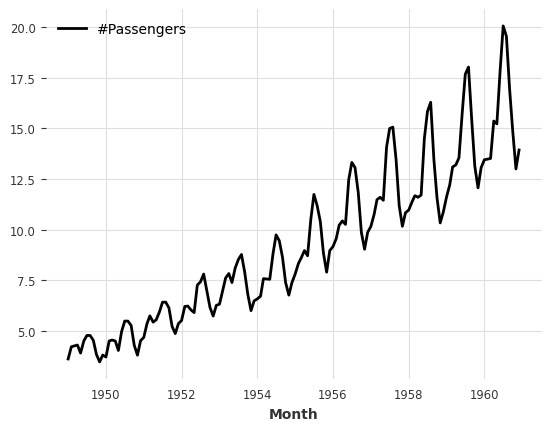

In [8]:
series.map(lambda ts, x: x / ts.days_in_month).plot()

**Adding some datetime attribute as an extra dimension (yielding a multivariate series):**

<Axes: xlabel='Month'>

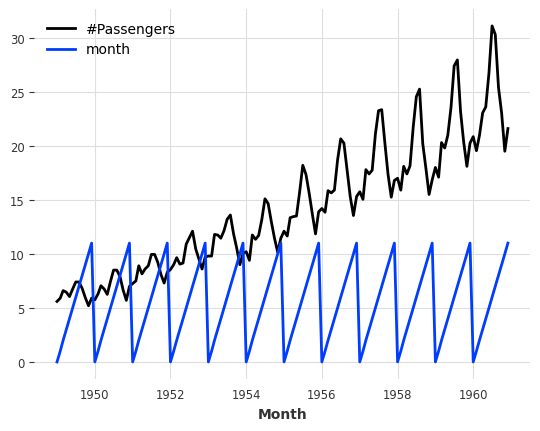

In [9]:
(series / 20).add_datetime_attribute("month").plot()

**Adding some binary holidays component:**

<Axes: xlabel='Month'>

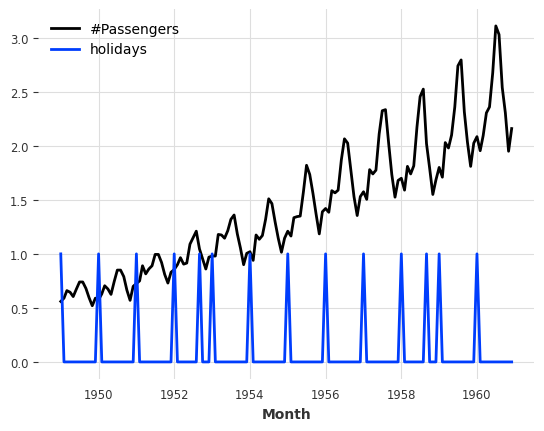

In [10]:
(series / 200).add_holidays("US").plot()

**differencing:**

<Axes: xlabel='Month'>

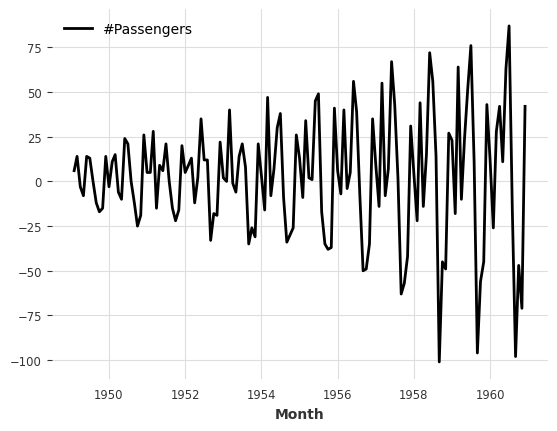

In [11]:
series.diff().plot()

**Filling missing values (using a `utils` function).**

Missing values are represented by `np.nan`.

<Axes: xlabel='time'>

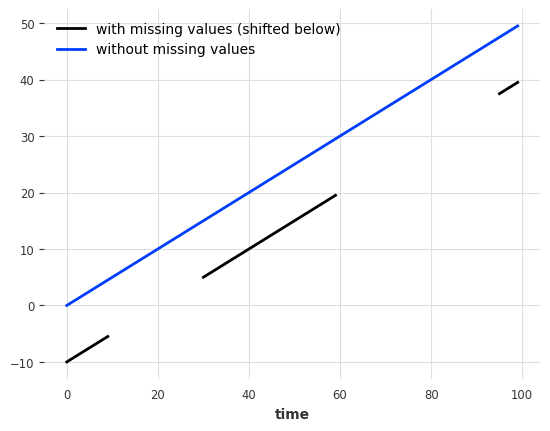

In [12]:
from darts.utils.missing_values import fill_missing_values

values = np.arange(50, step=0.5)
values[10:30] = np.nan
values[60:95] = np.nan
series_ = TimeSeries.from_values(values)

(series_ - 10).plot(label="with missing values (shifted below)")
fill_missing_values(series_).plot(label="without missing values")

## Creating a training and validation series
For what follows, we will split our `TimeSeries` into a training and a validation series. Note: in general, it is also a good practice to keep a test series aside and never touch it until the end of the process. Here, we just build a training and a validation series for simplicity.

The training series will be a `TimeSeries` containing values until January 1958 (excluded), and the validation series a `TimeSeries` containing the rest:

<Axes: xlabel='Month'>

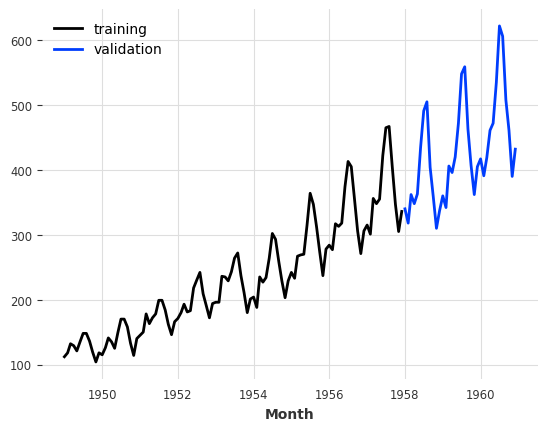

In [13]:
train, val = series.split_before(pd.Timestamp("19580101"))
train.plot(label="training")
val.plot(label="validation")

# Training forecasting models and making predictions
## Playing with toy models

There is a collection of "naive" baseline models in Darts, which can be very useful to get an idea of the bare minimum accuracy that one could expect. For example, the `NaiveSeasonal(K)` model always "repeats" the value that occured `K` time steps ago. 

In its most naive form, when `K=1`, this model simply always repeats the last value of the training series:

<Axes: xlabel='Month'>

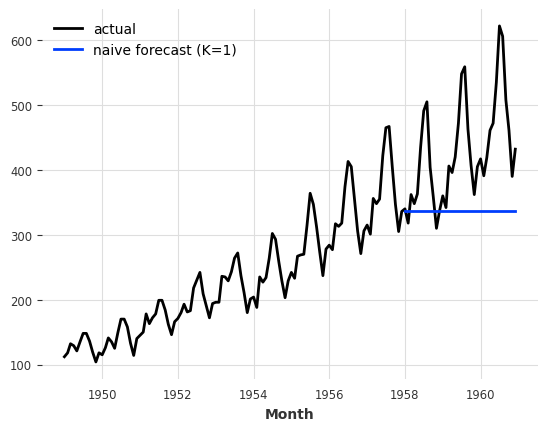

In [14]:
from darts.models import NaiveSeasonal

naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)
naive_forecast = naive_model.predict(36)

series.plot(label="actual")
naive_forecast.plot(label="naive forecast (K=1)")

It's very easy to fit models and produce predictions on `TimeSeries`. All the models have a `fit()` and a `predict()` function. This is similar to [Scikit-learn](https://scikit-learn.org/), except that it is specific to time series. The `fit()` function takes as argument the training time series on which to fit the model, and the `predict()` function takes as argument the number of time steps (after the end of the training series) over which to forecast.

### Inspect Seasonality
Our model above is perhaps a bit too naive. We can already improve by exploiting the seasonality in the data. It seems quite obvious that the data has a yearly seasonality, which we can confirm by looking at the auto-correlation function (ACF), and highlighting the lag `m=12`:

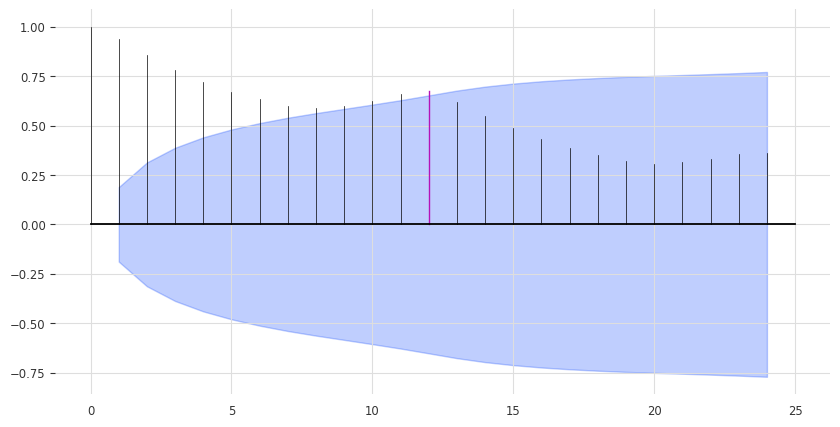

In [15]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train, m=12, alpha=0.05, max_lag=24)

The ACF presents a spike at x = 12, which suggests a yearly seasonality trend (highlighted in red). The blue zone determines the significance of the statistics for a confidence level of $\alpha = 5\%$. We can also run a statistical check of seasonality for each candidate period `m`:

In [16]:
for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 12.


### A less naive model
Let's try the `NaiveSeasonal` model again with a seasonality of 12:

<Axes: xlabel='Month'>

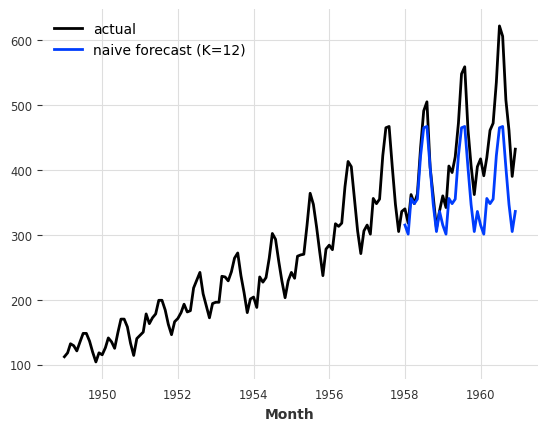

In [17]:
seasonal_model = NaiveSeasonal(K=12)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(36)

series.plot(label="actual")
seasonal_forecast.plot(label="naive forecast (K=12)")

This is better, but we are still missing the trend. Fortunately, there is also another naive baseline model capturing the trend, which is called `NaiveDrift`. This model simply produces linear predictions, with a slope that is determined by the first and last values of the training set:

<Axes: xlabel='Month'>

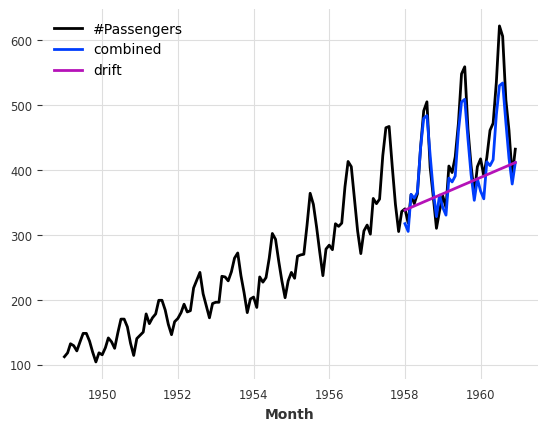

In [18]:
from darts.models import NaiveDrift

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(36)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

series.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

What happened there? We simply fit a naive drift model, and add its forecast to the seasonal forecast we had previously. We also subtract the last value of the training set from the result, so that the resulting combined forecast starts off with the right offset.

## Computing error metrics

This looks already like a fairly decent forecast, and we did not use any non-naive model yet. In fact - any model should be able to beat this. 

So what's the error we will have to beat? We will use the [Mean Absolute Percentage Error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error) (note that in practice there are often good reasons *not* to use the MAPE - we use it here as it is quite convenient and scale independent). In Darts it is a simple function call:

In [19]:
from darts.metrics import mape

print(
    f"Mean absolute percentage error for the combined naive drift + seasonal: {mape(series, combined_forecast):.2f}%."
)

Mean absolute percentage error for the combined naive drift + seasonal: 5.66%.


`darts.metrics` contains many more metrics to compare time series. The metrics will compare only common slices of series when the two series are not aligned, and parallelize computation over a large number of series pairs - but let's not get ahead of ourselves.

## Quickly try out several models
Darts is built to make it easy to train and validate several models in a unified way. Let's train a few more and compute their respective MAPE on the validation set:

In [20]:
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta


def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print(f"model {model} obtains MAPE: {mape(val, forecast):.2f}%")


eval_model(ExponentialSmoothing())
eval_model(TBATS())
eval_model(AutoARIMA())
eval_model(Theta())

model ExponentialSmoothing() obtains MAPE: 5.11%
model TBATS() obtains MAPE: 5.87%
model AutoARIMA() obtains MAPE: 11.65%
model Theta() obtains MAPE: 8.15%


Here, we only created these models with their default parameters. We can probably do better if we fine-tune to our problem. Let's try with the Theta method.

### Searching for hyper-parameters with the Theta method

The model `Theta` contains an implementation of Assimakopoulos and Nikolopoulos' Theta method. This method has had some success, particularly in the M3-competition.

Though the value of the Theta parameter is often set to 0 in applications, our implementation supports a variable value for parameter tuning purposes. Let's try to find a good value for Theta:

In [21]:
# Search for the best theta parameter, by trying 50 different values
thetas = 2 - np.linspace(-10, 10, 50)

best_mape = float("inf")
best_theta = 0

for theta in thetas:
    model = Theta(theta)
    model.fit(train)
    pred_theta = model.predict(len(val))
    res = mape(val, pred_theta)

    if res < best_mape:
        best_mape = res
        best_theta = theta

In [22]:
best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred_best_theta = best_theta_model.predict(len(val))

print(f"Lowest MAPE is: {mape(val, pred_best_theta):.2f}, with theta = {best_theta}.")

Lowest MAPE is: 4.40, with theta = -3.5102040816326543.


<Axes: xlabel='Month'>

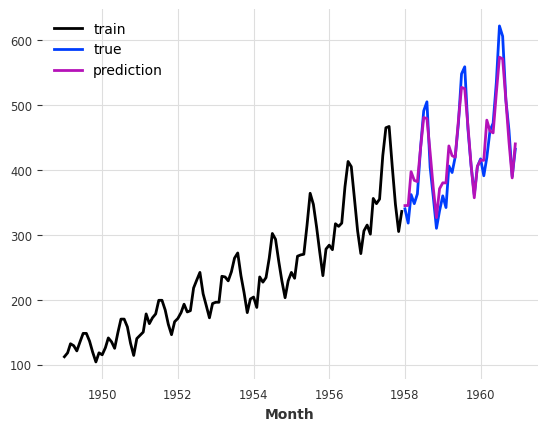

In [23]:
train.plot(label="train")
val.plot(label="true")
pred_best_theta.plot(label="prediction")

We can observe that the model with `best_theta` is so far the best we have, in terms of MAPE.

# Backtesting: simulate historical forecasting
So at this point we have a model that performs well on our validation set, and that's good. But, how can we know the performance we *would have obtained* if we *had been using this model* historically? 

Backtesting simulates predictions that would have been obtained historically with a given model. It can take a while to produce, since the model is (by default) re-trained every time the simulated prediction time advances.

Such simulated forecasts are always defined with respect to a *forecast horizon*, which is the number of time steps that separate the prediction time from the forecast time. In the example below, we simulate forecasts done for 3 months into the future (compared to prediction time). The result of calling `historical_forecasts()` is (by default) a `TimeSeries` which contains only the last predicted value of each of those 3-months ahead forecasts:

  0%|          | 0/58 [00:00<?, ?it/s]

MAPE = 7.99%


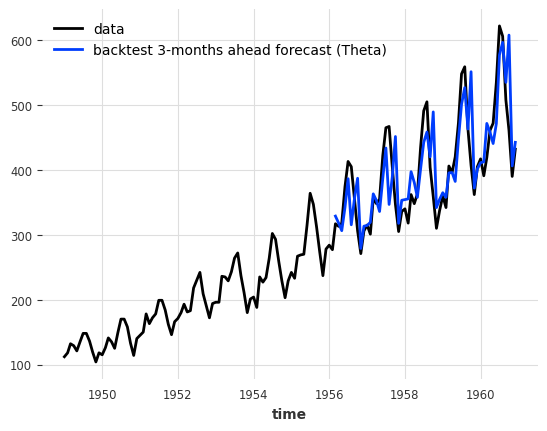

In [24]:
hfc_params = {
    "series": series,
    "start": pd.Timestamp("1956-01-01"),  # can also be a float for the fraction of the series to start at
    "forecast_horizon": 3,
    "verbose": True,
}
historical_fcast_theta = best_theta_model.historical_forecasts(last_points_only=True, **hfc_params)

series.plot(label="data")
historical_fcast_theta.plot(label="backtest 3-months ahead forecast (Theta)")
print(f"MAPE = {mape(series, historical_fcast_theta):.2f}%")

We can also retrieve all predicted values from each historical forecast, by setting `last_points_only=False`. With the `stride` parameter we define how many steps to move between two consecutative forecasts. We set it to 3 months, so that we can then concatenate the forecasts into a single `TimeSeries`.

  0%|          | 0/20 [00:00<?, ?it/s]

MAPE = 5.61%


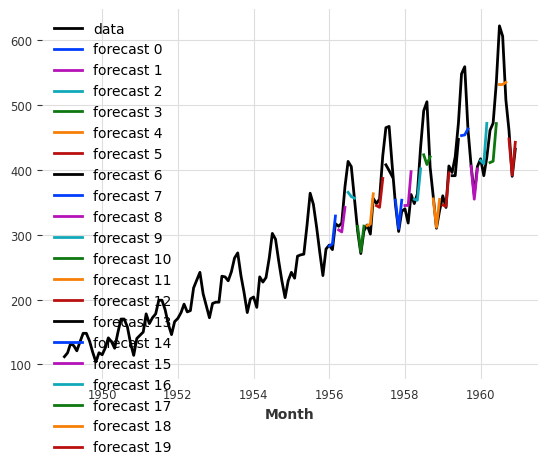

In [25]:
historical_fcast_theta_all = best_theta_model.historical_forecasts(last_points_only=False, stride=3, **hfc_params)

series.plot(label="data")
for idx, hfc in enumerate(historical_fcast_theta_all):
    hfc.plot(label=f"forecast {idx}")

from darts import concatenate
historical_fcast_theta_all = concatenate(historical_fcast_theta_all, axis=0)
print(f"MAPE = {mape(series, historical_fcast_theta_all):.2f}%")

So it seems that our best model on validation set is not doing so great anymore when we backtest it (did I hear overfitting :D)

To have a closer look at the errors, we can also use the `backtest()` method to obtain all the raw errors (say, MAPE errors) that would have been obtained by our model:

  0%|          | 0/58 [00:00<?, ?it/s]

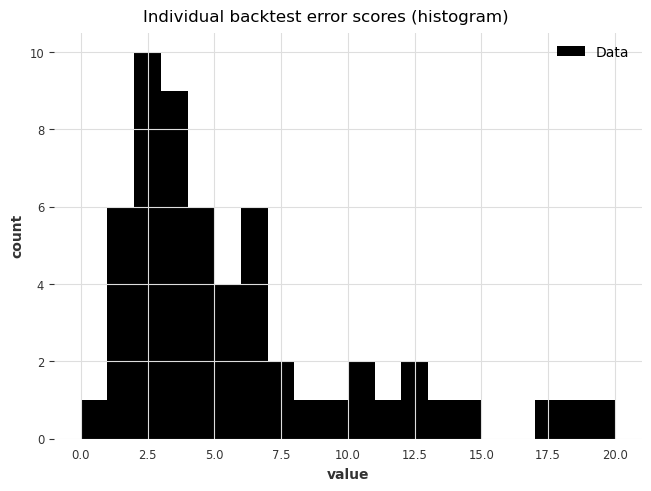

In [26]:
best_theta_model = Theta(best_theta)

raw_errors = best_theta_model.backtest(metric=mape, reduction=None, last_points_only=False, stride=1, **hfc_params)

from darts.utils.statistics import plot_hist

plot_hist(
    raw_errors,
    bins=np.arange(0, max(raw_errors), 1),
    title="Individual backtest error scores (histogram)",
)

Finally, using `backtest()` we can also get a simpler view of the average error over the historical forecasts:

In [27]:
average_error = best_theta_model.backtest(
    metric=mape, 
    reduction=np.mean,  # this is actually the default
    **hfc_params
)

print(f"Average error (MAPE) over all historical forecasts: {average_error:.2f}")

  0%|          | 0/58 [00:00<?, ?it/s]

Average error (MAPE) over all historical forecasts: 6.30


We could also for instance have specified the argument `reduction=np.median` to get the median MAPE instead.

Above, `backtest()` re-computed the historical forecasts every time we called it. We can also use some pre-computed forecasts to get the results much faster!

In [28]:
hfc_precomputed = best_theta_model.historical_forecasts(last_points_only=False, stride=1, **hfc_params)
new_error = best_theta_model.backtest(historical_forecasts=hfc_precomputed, last_points_only=False, stride=1, **hfc_params)

print(f"Average error (MAPE) over all historical forecasts: {new_error:.2f}")

  0%|          | 0/58 [00:00<?, ?it/s]

Average error (MAPE) over all historical forecasts: 6.30


### Looking at residuals
Let's look at the fitted value residuals of our current `Theta` model, i.e. the difference between the 1-step forecasts at every point in time obtained by fitting the model on all previous points, and the actual observed values:

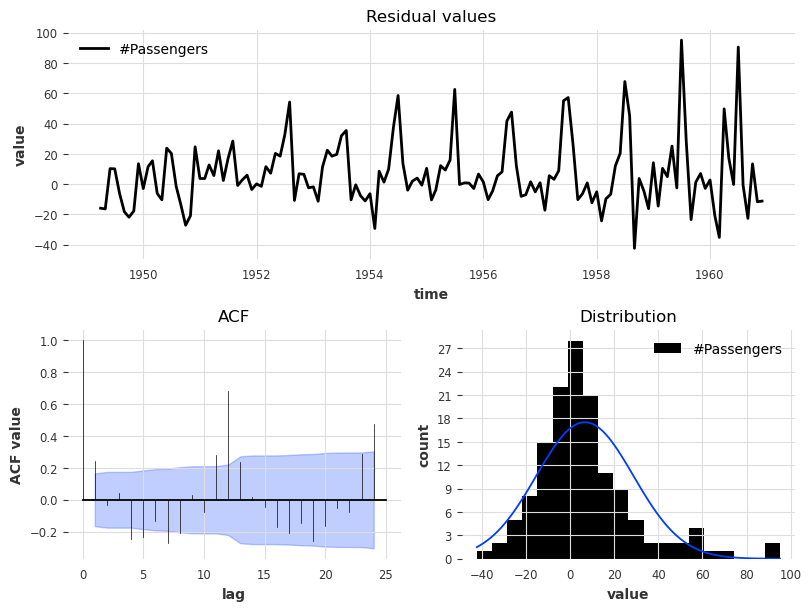

In [29]:
from darts.utils.statistics import plot_residuals_analysis

plot_residuals_analysis(best_theta_model.residuals(series))

We can see that the distribution is not centered at 0, which means that our `Theta` model is biased. We can also make out a large ACF value at lag equal to 12, which indicates that the residuals contain information that was not used by the model.

Our `residuals` method is actually much more powerful! It can be used to compute any *per-time step metric* from Darts (see a list [here](https://unit8co.github.io/darts/generated_api/darts.metrics.html)) even for multi-step forecasts. It also supports pre-computed historical forecasts similar to backtest.

Now let's check the distribution of absolute errors we get for each step in the 3 months forecasts.

Text(0.5, 1.0, 'Absolute errors per forecast step')

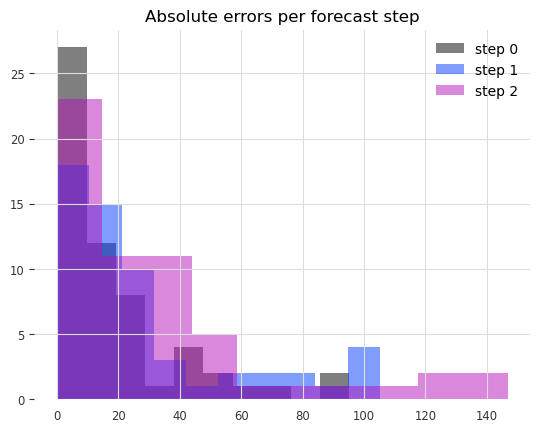

In [30]:
from darts.metrics import ae
residuals = best_theta_model.residuals(
    historical_forecasts=hfc_precomputed, 
    metric=ae,  # the absolute error per time step
    last_points_only=False, 
    values_only=True, # return a list of numpy arrays
    **hfc_params
)
residuals = np.concatenate(residuals, axis=1)[:, :, 0]

fig, ax = plt.subplots()
for forecast_step in range(len(residuals)):
    ax.hist(residuals[forecast_step], label=f"step {forecast_step}", alpha=0.5)
ax.legend()
ax.set_title("Absolute errors per forecast step")

We can clearly see that the errors increase the further ahead into the future we predict.

### A better model
Could we maybe do better with a simple `ExponentialSmoothing` model?

  0%|          | 0/58 [00:00<?, ?it/s]

MAPE = 4.42%


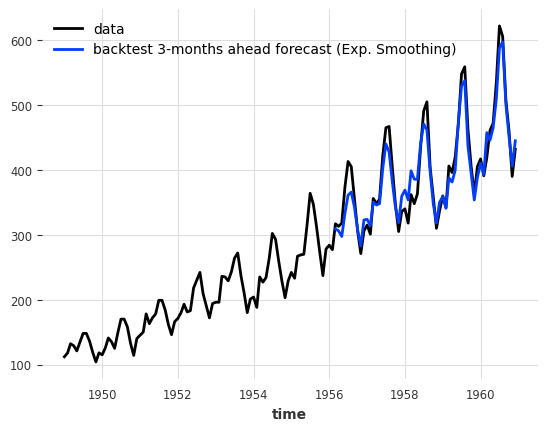

In [31]:
model_es = ExponentialSmoothing(seasonal_periods=12)
historical_fcast_es = model_es.historical_forecasts(**hfc_params)

series.plot(label="data")
historical_fcast_es.plot(label="backtest 3-months ahead forecast (Exp. Smoothing)")
print(f"MAPE = {mape(historical_fcast_es, series):.2f}%")

This is much better! We get a mean absolute percentage error of about 4-5% when backtesting with a 3-months forecast horizon in this case. 

  0%|          | 0/120 [00:00<?, ?it/s]

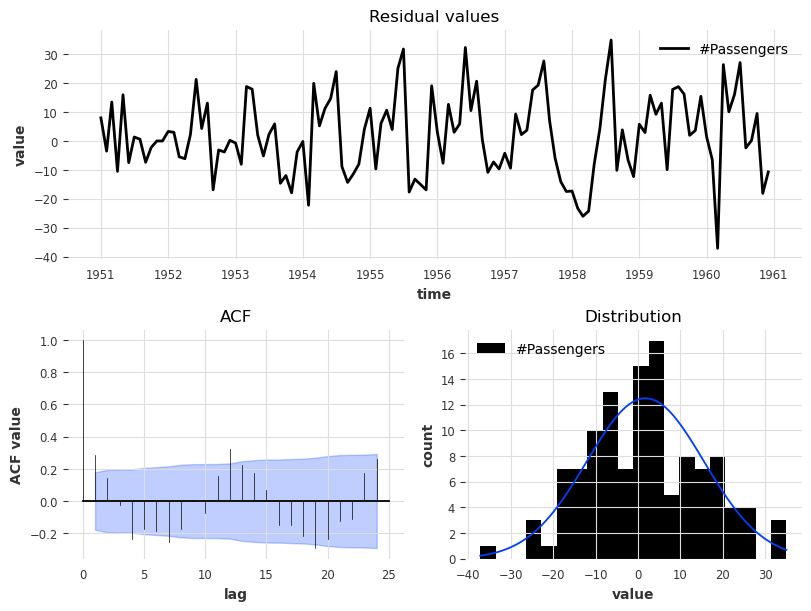

In [32]:
plot_residuals_analysis(model_es.residuals(series, verbose=True))

The residual analysis also reflects an improved performance in that we now have a distribution of the residuals centred at value 0, and the ACF values, although not insignificant, have lower magnitudes.

# Machine learning and global models
Darts has a rich support for machine learning and deep learning forecasting models; for instance:

* [RegressionModel](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.regression_model.html) can wrap around any sklearn-compatible regression model to produce forecasts (it has its own [section below](#Regression-forecasting-models)).
* [RNNModel](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.rnn_model.html) is a flexible RNN implementation, which can be used like DeepAR.
* [NBEATSModel](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.nbeats.html) implements the N-BEATS model.
* [TFTModel](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.tft_model.html) implements the Temporal Fusion Transformer model.
* [TCNModel](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.tcn_model.html) implements temporal convolutional networks.
* ...

In addition to supporting the same basic `fit()`/`predict()` interface as the other models, these models are also *global models*, as they support being trained on multiple time series (sometimes referred to as *meta learning*). 

This is a key point of using ML-based models for forecasting: more often than not, ML models (especially deep learning models) need to be trained on large amounts of data, which often means a large amount of separate yet related time series. 

In Darts, the basic way to specify multiple `TimeSeries` is using a `Sequence` of `TimeSeries` (for example, a simple list of `TimeSeries`).

## A toy example with two series
These models can be trained on thousands of series. Here, for the sake of illustration, we will load two distinct series - the air traffic passenger count and another series with the number of pounds of milk produced per cow monthly. We also cast our series to `np.float32` as that will slightly speedup the training:

<Axes: xlabel='Month'>

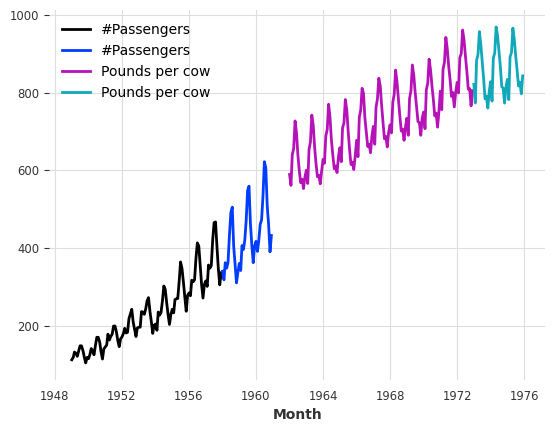

In [33]:
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset

series_air = AirPassengersDataset().load().astype(np.float32)
series_milk = MonthlyMilkDataset().load().astype(np.float32)

# set aside last 36 months of each series as validation set:
train_air, val_air = series_air[:-36], series_air[-36:]
train_milk, val_milk = series_milk[:-36], series_milk[-36:]

train_air.plot()
val_air.plot()
train_milk.plot()
val_milk.plot()

First, let's scale these two series between 0 and 1, as that will benefit most ML models. We will use a [Scaler](https://unit8co.github.io/darts/generated_api/darts.dataprocessing.transformers.scaler.html) for this:

<Axes: xlabel='Month'>

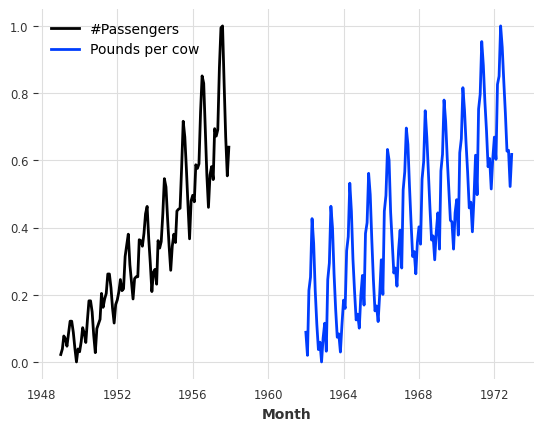

In [34]:
from darts.dataprocessing.transformers import Scaler

scaler = Scaler()
train_air_scaled, train_milk_scaled = scaler.fit_transform([train_air, train_milk])

train_air_scaled.plot()
train_milk_scaled.plot()

Note how we can scale several series in one go. We can also parallelize this sort of operations over multiple processors by specifying `n_jobs`.

## Using deep learning: example with N-BEATS

> Note: You can find a detailed user guide for our Neural Network Models (TorchForecastingModels) [here](https://unit8co.github.io/darts/userguide/torch_forecasting_models.html).

Next, we will build an [N-BEATS model](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.nbeats.html). This model can be tuned with many hyper-parameters (such as number of stacks, layers, etc). Here, for simplicity, we will use it with default hyper-parameters. The only two hyper-parameters that we have to provide are:

* `input_chunk_length`: this is the "lookback window" of the model - i.e., how many time steps of history the neural network takes as input to produce its output in a forward pass.
* `output_chunk_length`: this is the "forward window" of the model - i.e., how many time steps of future values the neural network outputs in a forward pass.

The `random_state` parameter is just here to get reproducible results.

Most neural networks in Darts require these two parameters. Here, we will use multiples of the seasonality. We are now ready to fit our model on our two series (by giving a list containing the two series to `fit()`):

In [35]:
from darts.models import NBEATSModel

model = NBEATSModel(input_chunk_length=24, output_chunk_length=12, random_state=42)

model.fit([train_air_scaled, train_milk_scaled], epochs=50, verbose=True);

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.2 M  | train
-------------------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
24.787    Total estimated model params size (MB)


Training: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Let's now get some forecasts 36 months ahead, for our two series. We can just use the `series` argument of the `predict()` function to tell the model which series to forecast. Importantly, the `output_chunk_length` does not directly constrain the forecast horizon `n` of `predict()`. Here, we trained the model with `output_chunk_length=12` and produce forecasts for `n=36` months ahead; this is simply done in an auto-regressive way behind the scenes (where the network recursively consumes its previous outputs).

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

<Axes: xlabel='Month'>

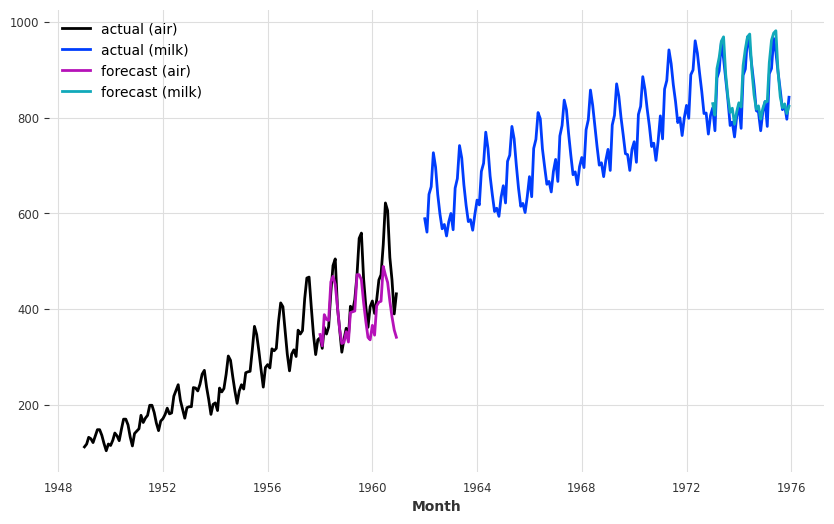

In [36]:
pred_air, pred_milk = model.predict(series=[train_air_scaled, train_milk_scaled], n=36)

# scale back:
pred_air, pred_milk = scaler.inverse_transform([pred_air, pred_milk])

plt.figure(figsize=(10, 6))
series_air.plot(label="actual (air)")
series_milk.plot(label="actual (milk)")
pred_air.plot(label="forecast (air)")
pred_milk.plot(label="forecast (milk)")

Our forecasts are actually not so terrible, considering that we use **one model** with default hyper-parameters to capture both air passengers and milk production!

The model seems quite OK at capturing the yearly seasonality, but misses the trend for the air series. In the next section, we will try to solve this issue using external data (covariates).

# Covariates: using external data
In addition to the **target** series (the series we are interested to forecast), many models in Darts also accept **covariates** series in input. Covariates are series that we do not want to forecast, but which can provide helpful additional information to the models. Both the targets and covariates can be multivariate or univariate.

There are two kinds of covariate time series in Darts:

* `past_covariates` are series not necessarily known ahead of the forecast time. They can for instance represent things that have to be measured and are not known upfront. Models do not use future values of `past_covariates` when making forecasts (only for global models when predicting with `n > output_chunk_length` due to auto-regression). For more info on past/future covariates, check out this [user guide](https://unit8co.github.io/darts/userguide/covariates.html).
* `future_covariates` are series which are known in advance, up to the forecast horizon. They can represent things such as calendar information, holidays, weather forecasts, etc. Models that accept `future_covariates` will look at the future values (up to the forecast horizon) when making forecasts.
* `static_covariates` are characteristics of the target series which do not change over time. They are embedded directly into the target series. They can represent things such as the category of product, country information, etc. For more info on static covariates, check out this [user guide](https://unit8co.github.io/darts/examples/15-static-covariates.html).

![covariates](static/images/covariates-highlevel.png)

Each covariate can potentially be multivariate. If you have several covariate series (such as month and year values), you should `stack()` or `concatenate()` them to obtain a multivariate series.

The covariates you provide can be longer than necessary. **Darts's model will automatically handle the extraction of relevant time frames for you!** You will receive an error if your covariates do not have a sufficient time span, though.

Not all models support every covariate type. You can find a model list [here](https://unit8co.github.io/darts/index.html#forecasting-models) stating which types they support.

Let's now build some external covariates containing both monthly and yearly values for our air and milk series.
In the cell below, we use the `darts.utils.timeseries_generation.datetime_attribute_timeseries()` function to generate series containing the month and year values, and we `concatenate()` these series along the `"component"` axis (same as `axis=1`) in order to obtain one covariate series with two components (month and year), per target series. For simplicity, we directly scale the month and year values to have them between 0 and 1:

Text(0.5, 1.0, 'one multivariate time series of 2 dimensions, containing covariates for the air series:')

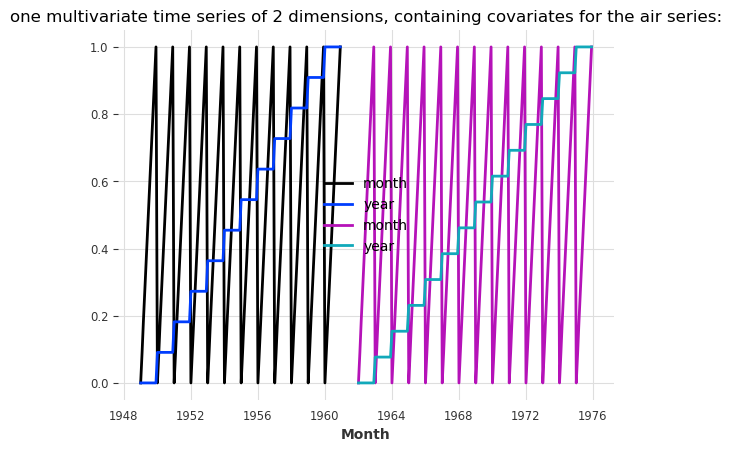

In [37]:
from darts import concatenate
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr

air_covs = concatenate(
    [
        dt_attr(series_air, "month", dtype=np.float32),
        dt_attr(series_air, "year", dtype=np.float32),
    ],
    axis="component",
)

milk_covs = concatenate(
    [
        dt_attr(series_milk, "month", dtype=np.float32),
        dt_attr(series_milk, "year", dtype=np.float32),
    ],
    axis="component",
)

air_covs, milk_covs = Scaler().fit_transform([air_covs, milk_covs])
air_covs.plot()
milk_covs.plot()
plt.title(
    "one multivariate time series of 2 dimensions, containing covariates for the air series:"
)

`NBEATSModel` supports only `past_covariates`. Therefore, even though our covariates represent calendar information and are known in advance, we will use them as `past_covariates` with N-BEATS. To train, all we have to do is give them as `past_covariates` to the `fit()` function, in the same order as the targets:

In [38]:
model = NBEATSModel(input_chunk_length=24, output_chunk_length=12, random_state=42)

model.fit(
    [train_air_scaled, train_milk_scaled],
    past_covariates=[air_covs, milk_covs],
    epochs=50,
    verbose=True,
);

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.6 M  | train
-------------------------------------------------------------
6.6 M     Trainable params
1.7 K     Non-trainable params
6.6 M     Total params
26.314    Total estimated model params size (MB)


Training: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Then to produce forecasts, we again have to provide our covariates as `past_covariates` to the `predict()` function.

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

<Axes: xlabel='Month'>

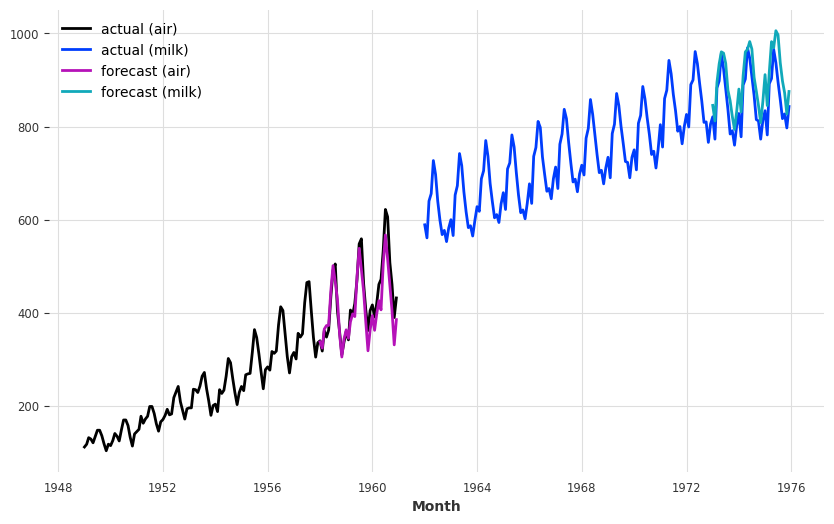

In [39]:
preds = model.predict(series=[train_air_scaled, train_milk_scaled], past_covariates=[air_covs, milk_covs], n=36)

# scale back:
pred_air, pred_milk = scaler.inverse_transform(preds)

plt.figure(figsize=(10, 6))
series_air.plot(label="actual (air)")
series_milk.plot(label="actual (milk)")
pred_air.plot(label="forecast (air)")
pred_milk.plot(label="forecast (milk)")

It seems that now the model captures the trend of the air series better (which also perturbs a bit the forecasts of the milk series). 

The model warning is pretty important. It tells us that future values of our `past_covariates` were used for prediction because we picked a hoizon `n > output_chunk_length` which activates auto-regression. The model will then cosume it's own predictions as input for the next prediction. Since the prediction point moves ahead, the model requires new values from the past covariates. These will however only be extracted from the past relative to the prediciton point (never from the forecast horizon itself)!

In our case it's fine to do this since we only use calendar information that we know in advance. If instead we used some features that we only know in the past, then we should only forecast with `n <= output_chunk_length`.

## Encoders: using covariates for free

Using covariates related to the calendar or time axis (such as months and years as in our example above) is so frequent that all of Darts' models with covariates support have a built-in functionality to generate them out of the box.

To easily integrate such covariates to your model, you can simply specify the `add_encoders` parameter at model creation. This parameter has to be a dictionary containing informations about what should be encoded as extra covariates. Here is an example of what such a dictionary could look like, for a model supporting both past and future covariates:

In [40]:
def extract_year(idx):
    """Extract the year each time index entry and normalized it."""
    return (idx.year - 1950) / 50


encoders = {
    "cyclic": {"future": ["month"]},
    "datetime_attribute": {"future": ["hour", "dayofweek"]},
    "position": {"past": ["absolute"], "future": ["relative"]},
    "custom": {"past": [extract_year]},
    "transformer": Scaler(),
}

In the above dictionary, the following things are specified:

* The month should be used as a future covariate, with a cyclic (sin/cos) encoding.
* The hour and day-of-the-week should be used as future covariates.
* The absolute position (time step in the series) should be used as past covariates.
* The relative position (w.r.t the forecasting time) should be used as future covariates.
* An additional custom function of the year should be used as past covariates.
* All the above covariates should be scaled using a `Scaler`, which will be fit upon calling the model `fit()` function and used afterwards to transform the covariates.

We refer to [the API doc](https://unit8co.github.io/darts/generated_api/darts.dataprocessing.encoders.encoders.html#sequentialencoder) for more informations about how to use encoders. Note that lambda functions cannot be used as they are not pickable.

To replicate our example with month and year used as past covariates with N-BEATS, we can use some encoders as follows:

In [41]:
encoders = {"datetime_attribute": {"past": ["month", "year"]}, "transformer": Scaler()}

Now, the whole training of the N-BEATS model with these covariates looks as follows:

In [42]:
model = NBEATSModel(
    input_chunk_length=24,
    output_chunk_length=12,
    add_encoders=encoders,
    random_state=42,
)

model.fit([train_air_scaled, train_milk_scaled], epochs=50, verbose=True);

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.6 M  | train
-------------------------------------------------------------
6.6 M     Trainable params
1.7 K     Non-trainable params
6.6 M     Total params
26.314    Total estimated model params size (MB)


Training: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


And get some forecasts for the air passengers series:

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

<Axes: xlabel='Month'>

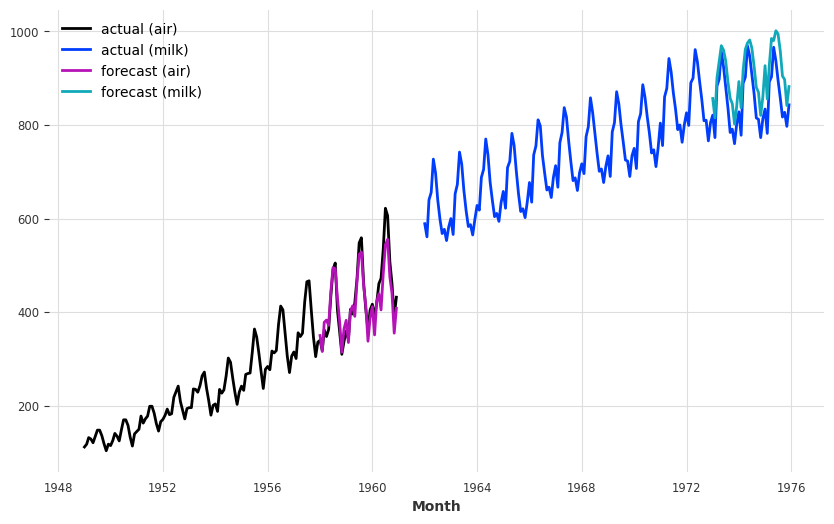

In [43]:
preds = model.predict(series=[train_air_scaled, train_milk_scaled], n=36, show_warnings=False)

# scale back:
pred_air, pred_milk = scaler.inverse_transform(preds)

plt.figure(figsize=(10, 6))
series_air.plot(label="actual (air)")
series_milk.plot(label="actual (milk)")
pred_air.plot(label="forecast (air)")
pred_milk.plot(label="forecast (milk)")

# Regression forecasting models

> Note: You can find a detailed example notebook for our RegressionModel [here](https://unit8co.github.io/darts/examples/20-RegressionModel-examples.html).

[RegressionModels](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.regression_model.html) are forecasting models which wrap around sklearn-compatible regression models. The inner regression model is used to predict future values of the target series, as a function of certain lags of the target, past and future covariates. Behind the scenes, the time series are tabularized in order to build a training dataset in the right format. 

By default, the `RegressionModel` will do a linear regression. It is very easy to use any desired sklearn-compatible regression model by specifying the `model` parameter, but for convenience Darts also provides a couple of ready-made models out of the box:

* [LinearRegressionModel](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.linear_regression_model.html) wraps around `sklearn.linear_model.LinearRegression` (accepting the same kwargs).
* [RandomForest](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.random_forest.html) wraps around `sklearn.ensemble.RandomForestRegressor`.
* [LightGBMModel](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.lgbm.html) wraps around `lightbm`.
* [XGBModel](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.xgboost.html) wraps around `xgboost`.
* [CatBoostModel](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.catboost_model.html) wraps around `catboost`.

For example, this is what fitting a Bayesian ridge regression to our toy two-series problem looks like:

In [44]:
from darts.models import RegressionModel
from sklearn.linear_model import BayesianRidge

model = RegressionModel(lags=72, lags_future_covariates=[-6, 0], model=BayesianRidge())

model.fit(
    [train_air_scaled, train_milk_scaled], future_covariates=[air_covs, milk_covs]
);

Several things happened above:

* `lags=72` is telling the `RegressionModel` to look at the past 72 lags / months of the target.
* In addition, `lags_future_covariates=[-6, 0]` means that the model will also look at lags of the `future_covariates` we provide. Here we specify the exact lags we want the models to take into account; the "-6th" and the "0th" lag. The "0th" lag means the "current" lag (i.e., at the time step being forecasted); obviously, knowning this lag requires knowing the data in advance (hence the fact we are using `future_covariates`). Similarly, `-6` means we also look at the value of the covariates 6 months before the forecasted time step (which also requires to know the covariates in advance if we are forecasting at a horizon more than 6 steps ahead).
* `model=BayesianRidge()` provides the actual inner regression model.

Now let's get some forecasts:

<Axes: xlabel='Month'>

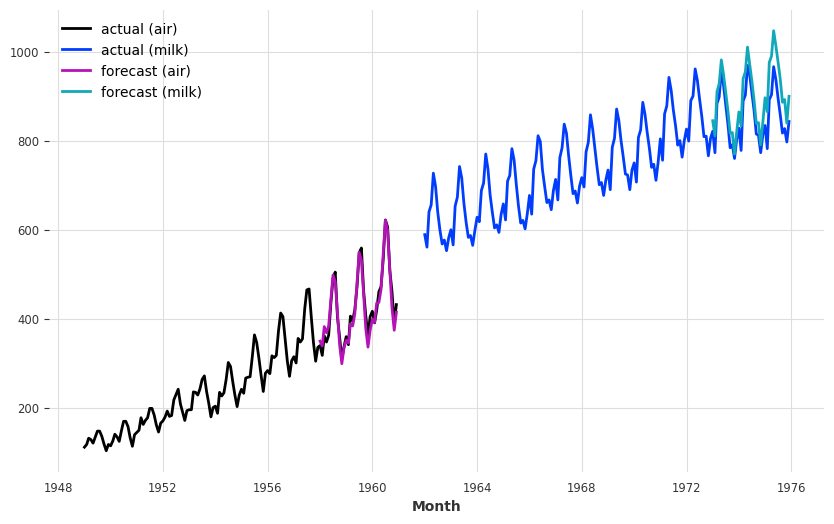

In [45]:
preds = model.predict(
    series=[train_air_scaled, train_milk_scaled],
    future_covariates=[air_covs, milk_covs],
    n=36,
)

# scale back:
pred_air, pred_milk = scaler.inverse_transform(preds)

plt.figure(figsize=(10, 6))
series_air.plot(label="actual (air)")
series_milk.plot(label="actual (milk)")
pred_air.plot(label="forecast (air)")
pred_milk.plot(label="forecast (milk)")

Note how we obtained the forecasts for the two time series at once above. Similarly, we can also get some metrics over sequences of series:

In [46]:
mape([series_air, series_milk], [pred_air, pred_milk])

[3.4355457, 5.1290045]

or the average metric over "all" series:

In [47]:
mape([series_air, series_milk], [pred_air, pred_milk], series_reduction=np.mean)

4.282275

By the way: similarly to transformers such as `Scaler`, computing metrics can be parallelized over `N` processors when executed over many series pairs by specifying `n_jobs=N`.

It seems that this model performs well on the Air traffic series, how does it do when we backtest it on this one series?

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/58 [00:00<?, ?it/s]

MAPE = 3.76%


<Axes: xlabel='time'>

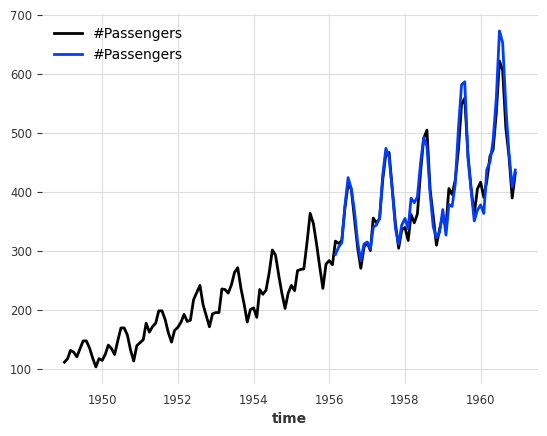

In [48]:
bayes_ridge_model = RegressionModel(
    lags=72, lags_future_covariates=[0], model=BayesianRidge()
)

backtest = bayes_ridge_model.historical_forecasts(
    future_covariates=air_covs, **hfc_params
)

print(f"MAPE = {mape(series_air, backtest):.2f}%")
series_air.plot()
backtest.plot()

Our best model so far!

# Sample Weights

All our global models (regression-, ensemble-, and neural network models) support sample weights for training. They are applied per observation, label (each step in `output_chunk_length`), and component. This can be very useful to:

- weigh certain time frames more than others (e.g. decaying weights the further the points in the past, higher weights for times with more business value, ...) 
- reduce / remove the effect of outliers or missing values on the model

Let's just introduce some outliers to the air passengers series and see how a linear regression model with a 12 months lookback window (`lags=12`) performs on this data.

  0%|          | 0/57 [00:00<?, ?it/s]

MAPE = 26.40%


<Axes: xlabel='time'>

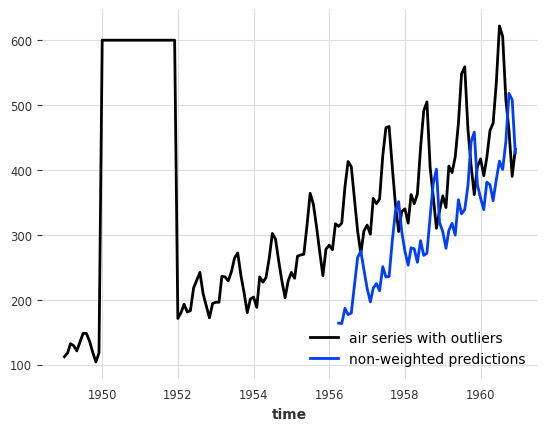

In [49]:
# convert to pandas DataFrame and add some outliers
air_df = series_air.pd_dataframe()
outlier_mask = (air_df.index.year >= 1950) & (air_df.index.year <= 1951)
air_df.loc[outlier_mask] = 600.
air_outlier = TimeSeries.from_dataframe(air_df)

from darts.models import LinearRegressionModel
model_lin = LinearRegressionModel(lags=12, lags_future_covariates=[0])
hist_fc_kwargs = {
    "series": air_outlier,
    "future_covariates": air_covs,
    "start": 0.6,
    "forecast_horizon": 3,
    "verbose": True,
    "show_warnings": False
}
backtest = model_lin.historical_forecasts(**hist_fc_kwargs)

print(f"MAPE = {mape(air_outlier, backtest):.2f}%")
air_outlier.plot(label="air series with outliers")
backtest.plot(label="non-weighted predictions")

This doesn't look very good. It would be great if we could ignore the outliers somehow. And this is where sample weights come in!

In Darts, sample weights are treated like covariates - they are defined as `TimeSeries` themselves. Thanks to that our models can  automatically extract the relevant time frames for us!

Let's create a weights series in which we set all outlier times to `0.` and the remaining times to `1.`. We also set the 12 months after the last outlier to `0.`, since these times fall into the lookback window of our model. Otherwise we would still have some outliers in the model input.

<Axes: xlabel='Month'>

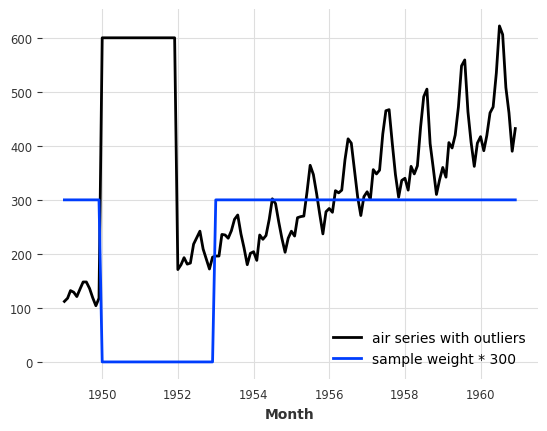

In [50]:
weight_mask = (air_df.index.year >= 1950) & (air_df.index.year <= 1952)
sample_weight = np.ones((len(air_df), 1))
sample_weight[weight_mask, 0] = 0.
sample_weight = air_outlier.with_values(sample_weight)

# and plot the results
air_outlier.plot(label="air series with outliers")
(sample_weight * 300).plot(label="sample weight * 300")

Now we can train the models with the sample weights using methods `fit()`, `historical_forecasts`, `backtest()`, ...

  0%|          | 0/57 [00:00<?, ?it/s]

MAPE = 5.19%


<Axes: xlabel='time'>

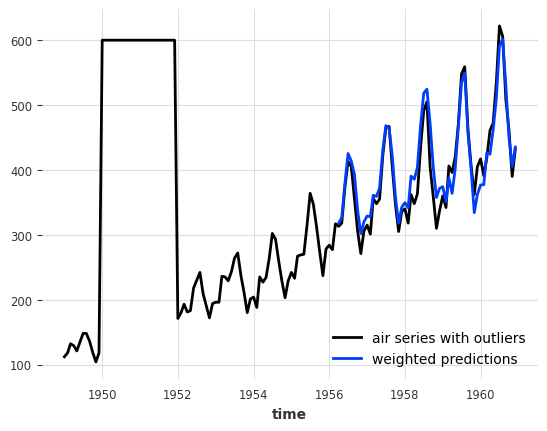

In [51]:
model_lin = LinearRegressionModel(lags=12, lags_future_covariates=[0])
backtest_weighted = model_lin.historical_forecasts(sample_weight=sample_weight, **hist_fc_kwargs)

print(f"MAPE = {mape(series_air, backtest_weighted):.2f}%")
air_outlier.plot(label="air series with outliers")
backtest_weighted.plot(label="weighted predictions")

Wow, this looks great! We managed to completely remove the negative impact of the outliers on our model!

**Note:** our sample weights also support multi-horizon forecasts, multiple time series, multivariate series, and weights for evaluation sets (if the model support it) 

# Forecast Start Shifting

We might also be interested in forecasts starting with an offset after the end of our target series. This can be useful for example:

- In (Day-) Ahead Markets, where (each day) we need to make some biddings for a future point in time (next day) - we are not really interested in what happens between now and that future point in time. We can reduce model complexity by only focusing on times of interest.
- When are covariates (or target series) are reported with a delay

All our global models support such predictions with an offset through model creation parameter `output_chunk_shift` - the number of steps to shift the first predicted step into the future.

With an output shift, the model cannot perform auto-regression anymore. So let's create a linear model that directly predicts the next 12 months with an offset of 12 months.

<Axes: xlabel='Month'>

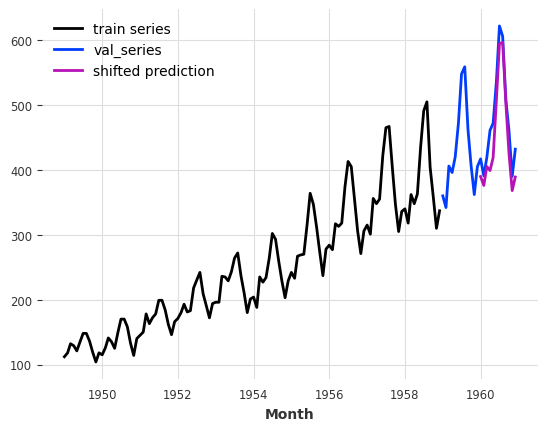

In [52]:
model_shifted = LinearRegressionModel(
    lags=12, 
    lags_future_covariates=(0, 12),
    output_chunk_length=12,
    output_chunk_shift=12,
)

model_shifted.fit(series_air[:-24], future_covariates=air_covs)
preds = model_shifted.predict(n=12)

series_air[:-24].plot(label="train series")
series_air[-24:].plot(label="val_series")
preds.plot(label="shifted prediction")

We see that the prediction starts 12 months after the end of the training series.

# Probabilistic forecasts

Most models in Darts support probabilistic forecasts (some local models and all regression-, ensemble- and neural network models). The full support list is [available on the Darts README page](https://github.com/unit8co/darts#forecasting-models).


## With Local Models

For local models (`ARIMA`, `ExponentialSmoothing`, ...), we can simply specify a `num_samples` parameter when calling `predict()`. The returned `TimeSeries` will then contain  `num_samples` Monte Carlo samples describing the distribution of the time series' values. The advantage of relying on Monte Carlo samples (in contrast to, say, explicit confidence intervals) is that they can be used to describe any parametric or non-parametric joint distribution over components, and compute arbitrary quantiles.

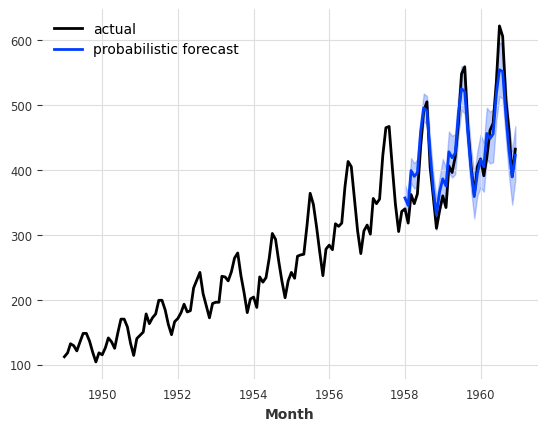

In [53]:
model_es = ExponentialSmoothing()
model_es.fit(train)
probabilistic_forecast = model_es.predict(len(val), num_samples=500)

series.plot(label="actual")
probabilistic_forecast.plot(label="probabilistic forecast")
plt.legend()
plt.show()

## With Neural Network Models (TorchForecastingModel)

With neural networks, we have to use a `Likelihood` object at model creation. The likelihoods specify which distribution the model will try to fit, along with potential prior values for the distributions' parameters. The full list of available likelihoods is [available in the docs](https://unit8co.github.io/darts/generated_api/darts.utils.likelihood_models.html).

Next to the distributions, we also support `QuantileRegression` as likelihood, which estimates future quantile values of the target series.

Using likelihoods is easy. For instance, here is what training an `TCNModel` to fit a Laplace likelihood looks like:

In [54]:
from darts.models import TCNModel
from darts.utils.likelihood_models import LaplaceLikelihood

model = TCNModel(
    input_chunk_length=24,
    output_chunk_length=12,
    random_state=42,
    likelihood=LaplaceLikelihood(),
)

model.fit(train_air_scaled, epochs=400, verbose=True);

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 166    | train
-------------------------------------------------------------
166       Trainable params
0         Non-trainable params
166       Total params
0.001     Total estimated model params size (MB)


Training: |                                               | 0/? [00:00<?, ?it/s]

[W NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.
`Trainer.fit` stopped: `max_epochs=400` reached.


### Probabilistic Sample Predictions
Then to get probabilistic forecasts, we again only need to specify some `num_samples >> 1`. This will sample from predicted distribution.

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Only 1 TimeSeries (lists) were provided which is lower than the number of series (n=2) used to fit Scaler. This can result in a mismatch between the series and the underlying transformers.


<Axes: xlabel='Month'>

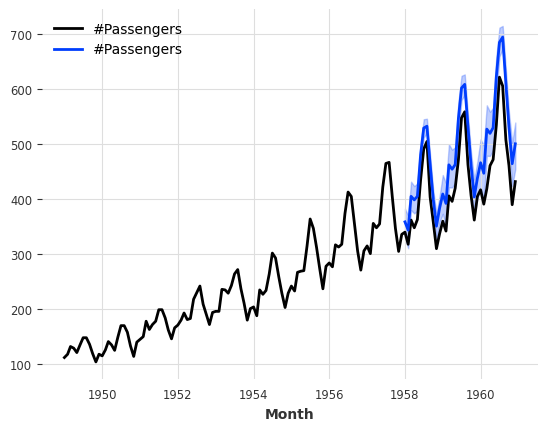

In [55]:
pred = model.predict(n=36, num_samples=500)

# scale back:
pred = scaler.inverse_transform(pred)

series_air.plot()
pred.plot()

### Direct Parameter Predicitons

The great thing about our likelihoods is that instead of sampling from the distribution/quantiles, we can directly predict the distribution/quantile parameters.
For this, we only have to set `predict_likelihood_parameters=True`.

Below we get the predicted location (mu) and scale (b) of the laplace distribution (in the scaled space between 0 and 1).

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

<Axes: xlabel='Month'>

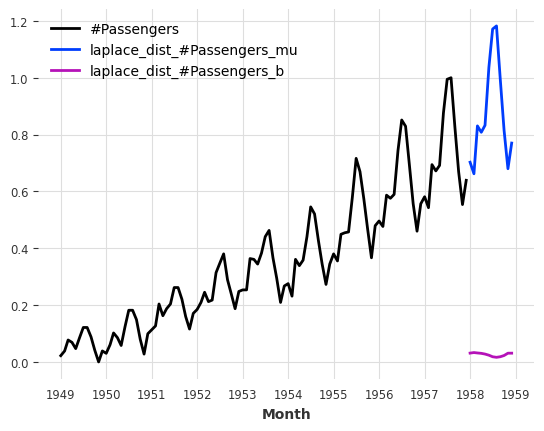

In [56]:
pred = model.predict(n=12, predict_likelihood_parameters=True)

train_air_scaled.plot()
pred.plot(label="laplace_dist")

Furthermore, we could also for instance specify that we have some prior belief that the scale of the distribution is about $0.1$ (in the transformed domain), while still capturing some time dependency of the distribution, by specifying `prior_b=.1`.

Behind the scenes this will regularize the training loss with a Kullback-Leibler divergence term.

In [57]:
model = TCNModel(
    input_chunk_length=24,
    output_chunk_length=12,
    random_state=42,
    likelihood=LaplaceLikelihood(prior_b=0.1),
)

model.fit(train_air_scaled, epochs=400, verbose=True);

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 166    | train
-------------------------------------------------------------
166       Trainable params
0         Non-trainable params
166       Total params
0.001     Total estimated model params size (MB)


Training: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Only 1 TimeSeries (lists) were provided which is lower than the number of series (n=2) used to fit Scaler. This can result in a mismatch between the series and the underlying transformers.


<Axes: xlabel='Month'>

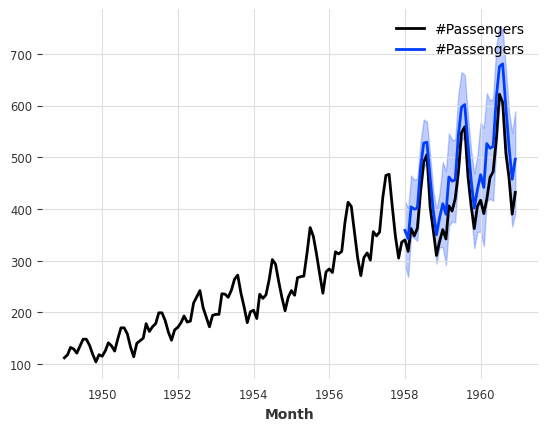

In [58]:
pred = model.predict(n=36, num_samples=500)

# scale back:
pred = scaler.inverse_transform(pred)

series_air.plot()
pred.plot()

By default `TimeSeries.plot()` shows the median as well as the 5th and 95th percentiles (of the marginal distributions, if the `TimeSeries` is multivariate). It is possible to control this:

<Axes: xlabel='Month'>

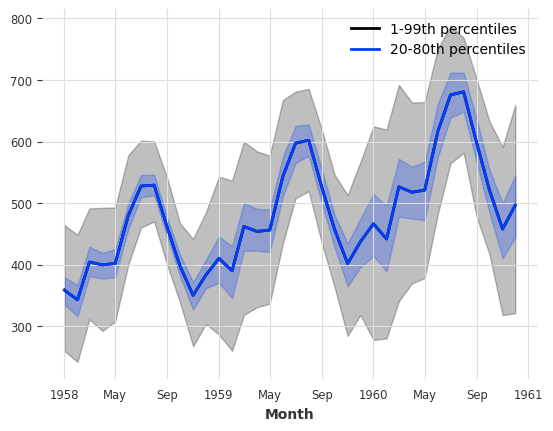

In [59]:
pred.plot(low_quantile=0.01, high_quantile=0.99, label="1-99th percentiles")
pred.plot(low_quantile=0.2, high_quantile=0.8, label="20-80th percentiles")

### Types of distributions
The likelihood has to be compatible with the domain of your time series' values. For instance [PoissonLikelihood](https://unit8co.github.io/darts/generated_api/darts.utils.likelihood_models.html#darts.utils.likelihood_models.PoissonLikelihood) can be used on discrete positive values, [ExponentialLikelihood](https://unit8co.github.io/darts/generated_api/darts.utils.likelihood_models.html#darts.utils.likelihood_models.ExponentialLikelihood) can be used on real positive values, and [BetaLikelihood](https://unit8co.github.io/darts/generated_api/darts.utils.likelihood_models.html#darts.utils.likelihood_models.BetaLikelihood) on real values in $(0,1)$.

It is also possible to use [QuantileRegression](https://unit8co.github.io/darts/generated_api/darts.utils.likelihood_models.html#darts.utils.likelihood_models.QuantileRegression) to apply a quantile loss and fit some desired quantiles directly.

### Evaluating Probabilistic Forecasts
How can we evaluate the quality of probabilistic forecasts? By default, most metrics functions (such as `mape()`) will keep working but look only at the median forecast. It is also possible to use the Mean Quantile Loss metric `mql()`, which quantifies the error for each predicted quantiles. For quantile=0.5 (the median), it is identical to the Mean Absolute Error (MAE):

In [60]:
from darts.metrics import mql, mae

print(f"MAPE of median forecast: {mape(series_air, pred):.2f}")
print(f"MAE of median forecast: {mae(series_air, pred):.2f}")
for q in [0.05, 0.1, 0.5, 0.9, 0.95]:
    q_loss = mql(series_air, pred, q=q)
    print(f"quantile loss at quantile {q:.2f}: {q_loss:.2f}")

MAPE of median forecast: 12.16
MAE of median forecast: 51.73
quantile loss at quantile 0.05: 5.36
quantile loss at quantile 0.10: 13.24
quantile loss at quantile 0.50: 51.73
quantile loss at quantile 0.90: 20.74
quantile loss at quantile 0.95: 12.20


### Using Quantile Loss

Could we do better by fitting these quantiles directly? We can just use a `QuantileRegression` likelihood:

In [61]:
from darts.utils.likelihood_models import QuantileRegression

model = TCNModel(
    input_chunk_length=24,
    output_chunk_length=12,
    random_state=42,
    likelihood=QuantileRegression([0.05, 0.1, 0.5, 0.9, 0.95]),
)

model.fit(train_air_scaled, epochs=400, verbose=True);

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 208    | train
-------------------------------------------------------------
208       Trainable params
0         Non-trainable params
208       Total params
0.001     Total estimated model params size (MB)


Training: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Only 1 TimeSeries (lists) were provided which is lower than the number of series (n=2) used to fit Scaler. This can result in a mismatch between the series and the underlying transformers.


MAPE of median forecast: 5.13
quantile loss at quantile 0.05: 9.27
quantile loss at quantile 0.10: 14.12
quantile loss at quantile 0.50: 20.85
quantile loss at quantile 0.90: 11.85
quantile loss at quantile 0.95: 7.14


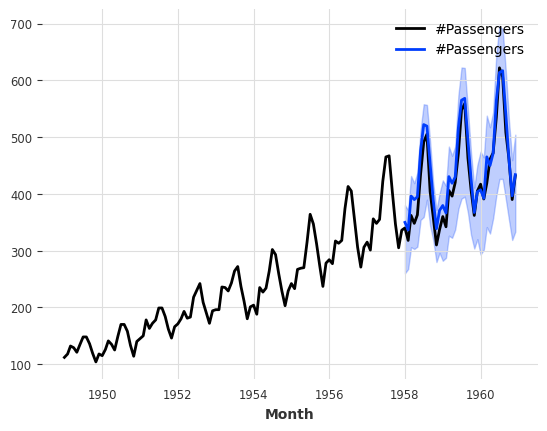

In [62]:
pred = model.predict(n=36, num_samples=500)

# scale back:
pred = scaler.inverse_transform(pred)

series_air.plot()
pred.plot()

print(f"MAPE of median forecast: {mape(series_air, pred):.2f}")
for q in [0.05, 0.1, 0.5, 0.9, 0.95]:
    q_loss = mql(series_air, pred, q=q)
    print(f"quantile loss at quantile {q:.2f}: {q_loss:.2f}")

## With Regression Models

Probailistic support for our `RegressionModels` is similiar to that of the neural networks. We have to specify a `likelihood` at model creation.
Instead of giving a likelihood object, we can simply pick one of `"quantile"` (with some `quantiles`) and `"poisson"`.

MAPE of median forecast: 8.48
quantile loss at quantile 0.05: 20.20
quantile loss at quantile 0.10: 25.45
quantile loss at quantile 0.50: 35.19
quantile loss at quantile 0.90: 11.30
quantile loss at quantile 0.95: 6.25


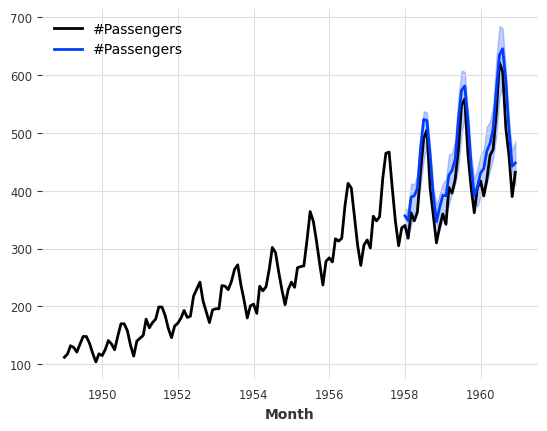

In [63]:
model = LinearRegressionModel(
    lags=24,
    lags_future_covariates=[0], 
    likelihood="quantile",
    quantiles=[0.05, 0.1, 0.5, 0.9, 0.95],
)
model.fit(train_air, future_covariates=air_covs)
pred = model.predict(n=36, num_samples=500)

series_air.plot()
pred.plot()

print(f"MAPE of median forecast: {mape(series_air, pred):.2f}")
for q in [0.05, 0.1, 0.5, 0.9, 0.95]:
    q_loss = mql(series_air, pred, q=q)
    print(f"quantile loss at quantile {q:.2f}: {q_loss:.2f}")

# Ensembling models
*Ensembling* is about combining the forecasts produced by several models, in order to obtain a final - and hopefully better forecast.

For instance, in our example of a [less naive model above](#A-less-naive-model), we manually combined a naive seasonal model with a naive drift model. Here, we will show how model forecasts can be automatically combined - naively using a `NaiveEnsembleModel`, or learned using `RegressionEnsembleModel`.

It is of course also possible to use `past` and/or `future_covariates` with ensemble model but they will be passed only to the forecasting models supporting them.

## Naive Ensembling

Naive ensembling just takes the average of the forecasts from several models. Darts `NaiveEnsembleModel` does exactly that and all through the same API as the forecasting models (fit, predict, historical forecasts, backtesting, ...).

  0%|          | 0/58 [00:00<?, ?it/s]

MAPE = 11.93%


<Axes: xlabel='time'>

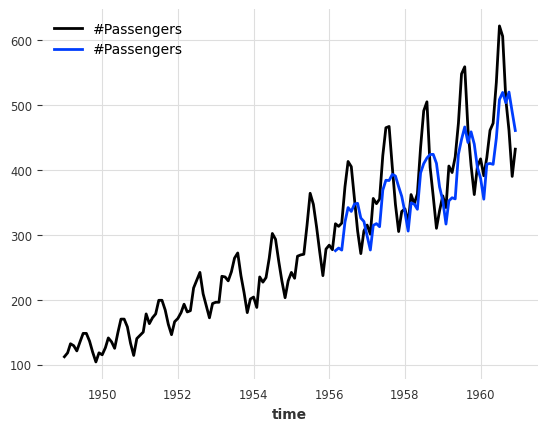

In [64]:
from darts.models import NaiveEnsembleModel

models = [NaiveDrift(), NaiveSeasonal(12)]

ensemble_model = NaiveEnsembleModel(forecasting_models=models)

backtest = ensemble_model.historical_forecasts(**hfc_params)

print(f"MAPE = {mape(backtest, series_air):.2f}%")
series_air.plot()
backtest.plot()

## Learned Ensembling

As expected in this case, the naive ensemble doesn't give great results (although in some cases it could!)

We can sometimes do better if we see the ensembling as a supervised regression problem: given a set of forecasts (features), find a model that combines them in order to minimise errors on the target.
This is what the `RegressionEnsembleModel` does. It accepts parameters:

* `forecasting_models` is a list of forecasting models whose predictions we want to ensemble.
* `regression_train_n_points` is the number of time steps to use for fitting the "ensemble regression" model (i.e., the inner model that combines the forecasts).
* `regression_model` is, optionally, a sklearn-compatible regression model or a Darts `RegressionModel` to be used for the ensemble regression. If not specified, a linear regression is used. Using a sklearn model is easy out-of-the-box, but using a `RegressionModel` allows to potentially take arbitrary lags of the individual forecasts as inputs of the regression model.
* and for more, read our this [user guide on ensembling models](https://unit8co.github.io/darts/examples/19-EnsembleModel-examples.html).

Once these elements are in place, a `RegressionEnsembleModel` can be used like a regular forecasting model:

  0%|          | 0/58 [00:00<?, ?it/s]

MAPE = 4.77


<Axes: xlabel='time'>

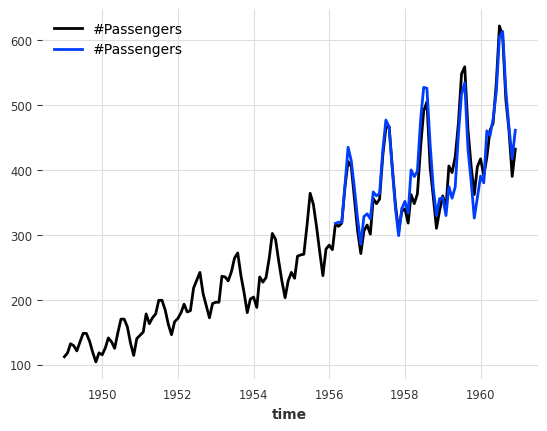

In [65]:
from darts.models import RegressionEnsembleModel
ensemble_model = RegressionEnsembleModel(
    forecasting_models=models, regression_train_n_points=12
)

backtest = ensemble_model.historical_forecasts(**hfc_params)

print(f"MAPE = {mape(backtest, series_air):.2f}")
series_air.plot()
backtest.plot()

We can also inspect the coefficients used to weigh the two inner models in the linear combination:

In [66]:
ensemble_model.fit(series_air)
ensemble_model.regression_model.model.coef_

array([0.01368849, 1.0980105 ], dtype=float32)

Ensemble models can also be probabilistic themselves! You can read about it in [our guide on ensembling models](https://unit8co.github.io/darts/examples/19-EnsembleModel-examples.html#).

`RegressionEnsembleModel` uses the *stacking* technique to train and combine the `forecasting_models`: each one of them is trained independently and the `regression_model` is then trained using their predictions as `future_covariates`.

# Filtering models
In addition to *forecasting* models, which are able to predict future values of series, Darts also contains a couple of helpful *filtering* models, which can model "in sample" series' values distributions.

## Fitting a Kalman Filter
`KalmanFilter` implements a [Kalman Filter](https://unit8co.github.io/darts/generated_api/darts.models.filtering.kalman_filter.html). The implementation relies on [nfoursid](https://nfoursid.readthedocs.io/en/latest/source/kalman.html), so it is for instance possible to provide a `nfoursid.kalman.Kalman` object containing a transition matrix, process noise covariance, observation noise covariance etc.

It is also possible to do system identification by calling `fit()` to "train" the Kalman Filter using the N4SID system identification algorithm:

<Axes: xlabel='Month'>

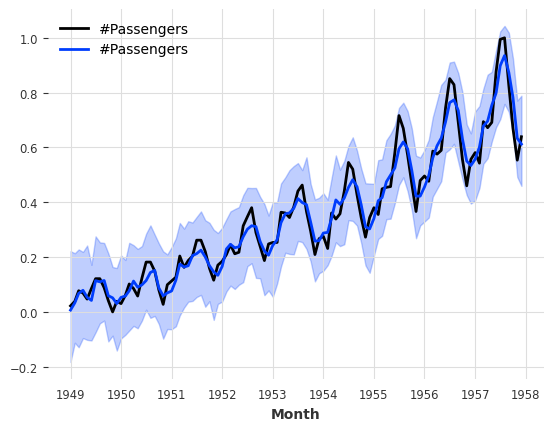

In [67]:
from darts.models import KalmanFilter

kf = KalmanFilter(dim_x=3)
kf.fit(train_air_scaled)
filtered_series = kf.filter(train_air_scaled, num_samples=100)

train_air_scaled.plot()
filtered_series.plot()

## Inferring missing values with Gaussian Processes

Darts also contains a `GaussianProcessFilter` which can be used for probabilistic modeling of series:

<Axes: xlabel='Month'>

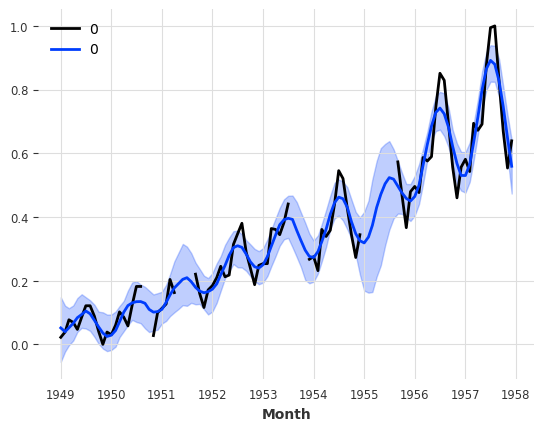

In [68]:
from darts.models import GaussianProcessFilter
from sklearn.gaussian_process.kernels import RBF

# create a series with holes:
values = train_air_scaled.values()
values[20:22] = np.nan
values[28:32] = np.nan
values[55:59] = np.nan
values[72:80] = np.nan
series_holes = TimeSeries.from_times_and_values(train_air_scaled.time_index, values)
series_holes.plot()

kernel = RBF()

gpf = GaussianProcessFilter(kernel=kernel, alpha=0.1, normalize_y=True)
filtered_series = gpf.filter(series_holes, num_samples=100)

filtered_series.plot()

# A Word of Caution
So is N-BEATS, exponential smoothing, or a Bayesian ridge regression trained on milk production the best approach for predicting the future number of airline passengers? Well, at this point it's actually hard to say exactly which one is best. Our time series is small, and our validation set is even smaller. In such cases, it's very easy to overfit the whole forecasting exercise to such a small validation set. That's especially true if the number of available models and their degrees of freedom is high (such as for deep learning models), or if we played with many models on a single test set (as done in this notebook). 

As data scientists, it is our responsibility to understand the extent to which our models can be trusted. So always take results with a grain of salt, especially on small datasets, and apply the scientific method before making any kind of forecast :) Happy modeling!

# Anomaly Detection

Darts also has an entire module on Time Series Anomaly Detection. For more info, read our [user guide on anomaly detection](https://unit8co.github.io/darts/examples/22-anomaly-detection-examples.html).